<a href="https://colab.research.google.com/github/paylace/wave/blob/main/6464%EC%9D%B4%EB%AF%B8%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import numpy as np

def create_test_grayscale_image(
    image_path='input_64x64_grayscale_image.png',
    image_width=64,
    image_height=64,
    pattern_type='gradient' # 'random', 'gradient', 'checkerboard'
):
    """
    지정된 패턴으로 64x64 흑백 테스트 이미지를 생성합니다.
    """

    if pattern_type == 'random':
        # 무작위 회색조 이미지 생성
        image_data = np.random.randint(0, 256, (image_height, image_width), dtype=np.uint8)
    elif pattern_type == 'gradient':
        # 가로 및 세로 그라데이션이 있는 이미지 생성
        image_data = np.zeros((image_height, image_width), dtype=np.uint8)
        for y in range(image_height):
            for x in range(image_width):
                # 가로 및 세로 방향으로 밝기가 변화하는 그라데이션
                image_data[y, x] = int((x / (image_width - 1)) * 128 + (y / (image_height - 1)) * 127)
    elif pattern_type == 'checkerboard':
        # 체스판 패턴 이미지 생성
        image_data = np.zeros((image_height, image_width), dtype=np.uint8)
        for y in range(image_height):
            for x in range(image_width):
                if (x // 8 + y // 8) % 2 == 0: # 8x8 블록 크기의 체스판
                    image_data[y, x] = 255 # 흰색
                else:
                    image_data[y, x] = 0   # 검은색
    else:
        print("경고: 알 수 없는 패턴 타입입니다. 'gradient' 패턴으로 기본 설정됩니다.")
        return create_test_grayscale_image(image_path, image_width, image_height, 'gradient')

    test_img = Image.fromarray(image_data, mode='L')
    test_img.save(image_path)
    print(f"테스트용 '{image_path}' 이미지가 '{pattern_type}' 패턴으로 생성되었습니다.")

if __name__ == "__main__":
    # 무작위 패턴 이미지 생성
    create_test_grayscale_image(image_path='input_64x64_grayscale_random.png', pattern_type='random')

    # 그라데이션 패턴 이미지 생성 (기본값)
    create_test_grayscale_image(image_path='input_64x64_grayscale_gradient.png', pattern_type='gradient')

    # 체스판 패턴 이미지 생성
    create_test_grayscale_image(image_path='input_64x64_grayscale_checkerboard.png', pattern_type='checkerboard')

    # `encode_image_to_sound` 함수와 함께 사용하기 위해 기본 이미지 경로로 하나 생성
    create_test_grayscale_image(image_path='input_64x64_grayscale_image.png', pattern_type='gradient')

테스트용 'input_64x64_grayscale_random.png' 이미지가 'random' 패턴으로 생성되었습니다.
테스트용 'input_64x64_grayscale_gradient.png' 이미지가 'gradient' 패턴으로 생성되었습니다.
테스트용 'input_64x64_grayscale_checkerboard.png' 이미지가 'checkerboard' 패턴으로 생성되었습니다.
테스트용 'input_64x64_grayscale_image.png' 이미지가 'gradient' 패턴으로 생성되었습니다.


In [ ]:
import numpy as np
from PIL import Image
import soundfile as sf

def encode_image_to_sound(
    image_path='input_64x64_grayscale_random.png', # 입력 64x64 회색조 이미지 경로
    output_audio_path='encoded_64x64_grayscale_sound.wav', # 출력 오디오 파일 경로
    image_width=64,
    image_height=64,
    sampling_rate=44100, # 오디오 샘플링 레이트
    duration=5,          # 오디오 길이 (초), 길수록 주파수 해상도 좋음

    # --- 주파수 설정 (가청 범위 내로 조정됨) ---
    # 총 64x64 = 4096개의 픽셀.
    # 200Hz 시작, 18000Hz 내에 모든 주파수가 오도록 freq_interval 조정
    # (18000 - 200) / 4096 = 약 4.34. 따라서 4Hz 간격 사용.
    base_frequency=200,  # 첫 픽셀의 기준 주파수 (Hz)
    freq_interval=4,     # 픽셀당 주파수 간격 (Hz)

    # --- 위상 설정 (디코딩 코드와 반드시 일치해야 함!) ---
    # 각 픽셀 위치에 따라 위상 변화 부여 (라디안 단위)
    # 예를 들어, x, y축 전체에서 위상이 pi/2까지 변하도록 설정
    # 기본값을 None으로 설정하고 함수 내에서 계산
    phase_step_x=None, # x축 1픽셀당 위상 변화 - None으로 변경
    phase_step_y=None # y축 1픽셀당 위상 변화 - None으로 변경
):
    """
    64x64 회색조 이미지를 읽어 소리 파일로 인코딩합니다.
    각 픽셀의 밝기는 사인파의 진폭으로, 위치는 주파수와 위상으로 인코딩됩니다.
    """

    # 위상 단계를 제공하지 않았다면 계산 - 이 로직은 그대로 유지
    if phase_step_x is None:
        phase_step_x = np.pi / (image_width * 2)
    if phase_step_y is None:
        phase_step_y = np.pi / (image_height * 2)

    # 이미지 로드 및 전처리
    try:
        img = Image.open(image_path).convert('L') # 8비트 회색조로 변환
        img = img.resize((image_width, image_height), Image.NEAREST) # 64x64로 강제 조정
        pixel_data = np.array(img)
        if pixel_data.shape != (image_height, image_width):
            raise ValueError(f"Image is not {image_width}x{image_height} after resizing.")
    except Exception as e:
        print(f"이미지 로드 및 처리 중 오류 발생: {e}")
        return

    print(f"'{image_path}' 이미지 인코딩 시작...")
    print(f"총 픽셀 수: {image_width * image_height}")
    print(f"사용 주파수 범위: {base_frequency} Hz ~ {base_frequency + (image_width * image_height - 1) * freq_interval} Hz (가청 범위 내)")
    print(f"오디오 길이: {duration} 초")

    # 오디오 파형 생성 준비
    total_samples = int(sampling_rate * duration)
    t = np.linspace(0, duration, total_samples, endpoint=False) # 시간 배열
    combined_waveform = np.zeros(total_samples) # 모든 픽셀의 사인파를 합칠 배열

    for y in range(image_height):
        for x in range(image_width):
            # 픽셀 밝기를 진폭으로 매핑 (0~255 -> 0.05~0.85)
            # 완전한 0이 되지 않도록 0.05를 더해 최소 진폭을 보장합니다.
            amplitude = (pixel_data[y, x] / 255.0) * 0.8 + 0.05

            # 픽셀 위치에 따라 고유 주파수 할당
            pixel_linear_index = y * image_width + x
            frequency = base_frequency + pixel_linear_index * freq_interval

            # 픽셀 위치에 따라 위상 할당
            phase = (x * phase_step_x + y * phase_step_y) % (2 * np.pi)

            # 사인파 생성 및 합성
            single_pixel_waveform = amplitude * np.sin(2 * np.pi * frequency * t + phase)
            combined_waveform += single_pixel_waveform

    # 클리핑 방지 및 볼륨 정규화 (최대 90% 볼륨)
    max_abs_amplitude = np.max(np.abs(combined_waveform))
    if max_abs_amplitude > 0:
        combined_waveform = combined_waveform / max_abs_amplitude * 0.9
    else:
        print("경고: 모든 픽셀이 검은색이어서 소리가 생성되지 않습니다.")
        combined_waveform = np.zeros(total_samples) # 혹시 모를 0 나누기 방지

    # WAV 파일로 저장
    sf.write(output_audio_path, combined_waveform, sampling_rate)
    print(f"인코딩된 소리가 '{output_audio_path}'에 저장되었습니다.")
    print("-" * 50)

# --- 인코딩 코드 실행 예시 ---
if __name__ == "__main__":
    # 테스트용 64x64 회색조 이미지 생성 (코드 실행 시 주석 해제)
    # 이 부분은 실제 이미지가 없을 때 임시로 이미지를 만들어줍니다.
    # from PIL import Image
    # # 무작위 회색조 이미지 생성
    # test_img_data = np.random.randint(0, 256, (64, 64), dtype=np.uint8)
    # # 그라데이션 이미지 생성 예시
    # # test_img_data = np.zeros((64,64), dtype=np.uint8)
    # # for i in range(64):
    # #     for j in range(64):
    # #         test_img_data[i,j] = int((i/63 * 128) + (j/63 * 127)) # 밝기 그라데이션
    # test_img = Image.fromarray(test_img_data, mode='L')
    # test_img.save('input_64x64_grayscale_image.png')
    # print("테스트용 'input_64x64_grayscale_image.png' 이미지가 생성되었습니다.")

    encode_image_to_sound(
        image_path='input_64x64_grayscale_random.png', # 이 경로에 64x64 이미지가 있어야 함
        output_audio_path='encoded_64x64_grayscale_sound.wav'
    )

'input_64x64_grayscale_random.png' 이미지 인코딩 시작...
총 픽셀 수: 4096
사용 주파수 범위: 200 Hz ~ 16580 Hz (가청 범위 내)
오디오 길이: 5 초
인코딩된 소리가 'encoded_64x64_grayscale_sound.wav'에 저장되었습니다.
--------------------------------------------------


'encoded_64x64_grayscale_sound.wav' 오디오 파일 디코딩 시작...
오디오 길이: 5.00 초, 샘플링 레이트: 44100 Hz
FFT 주파수 해상도: 0.2000 Hz


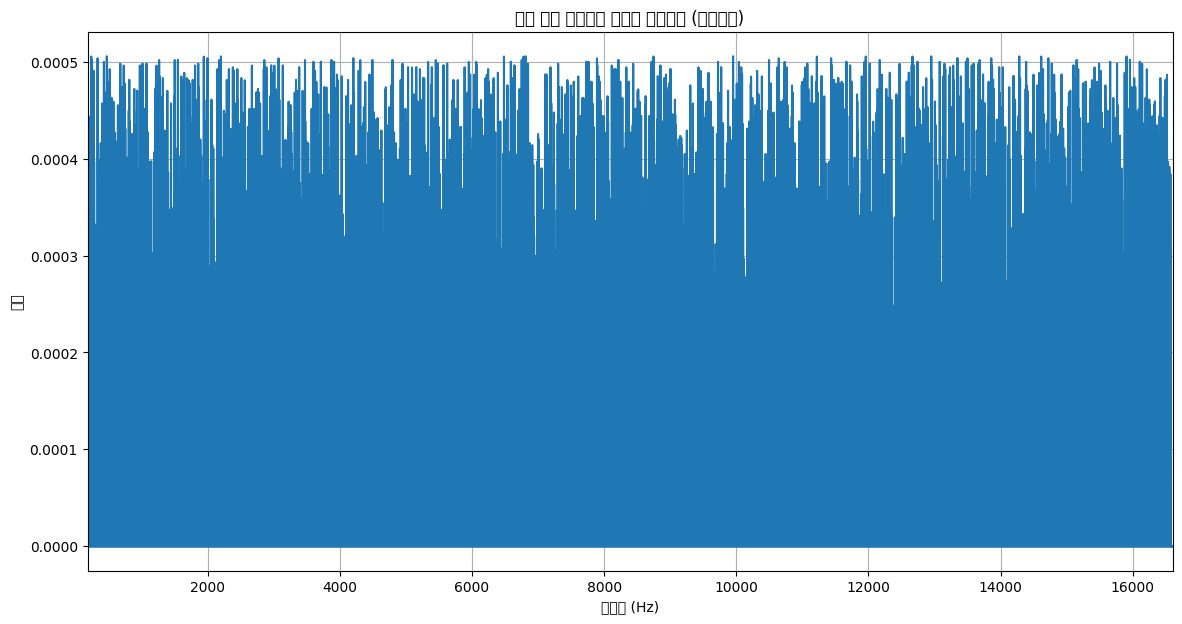


--- FFT 스펙트럼 분석 및 픽셀 매핑 ---

복원에 사용될 최대 감지 진폭: 0.000506

복원된 이미지가 'reconstructed_64x64_image.png'에 저장되었습니다.
--------------------------------------------------


In [ ]:
import numpy as np
from scipy.fft import fft, fftfreq
import soundfile as sf
from PIL import Image
import matplotlib.pyplot as plt

def decode_sound_to_image(
    audio_path='encoded_64x64_grayscale_sound.wav', # 입력 오디오 파일 경로
    output_image_path='reconstructed_64x64_image.png', # 출력 이미지 파일 경로
    image_width=64,
    image_height=64,

    # --- 인코딩 코드와 동일한 파라미터 사용 ---
    sampling_rate=44100,
    base_frequency=200,
    freq_interval=4,
    phase_step_x=np.pi / (64 * 2),
    phase_step_y=np.pi / (64 * 2),

    # --- 디코딩 임계값 (조정 필요 가능성 높음!) ---
    # 이 값보다 작은 진폭은 노이즈로 간주하여 0으로 처리합니다.
    # 스펙트럼 그래프를 보고, 실제 신호 봉우리보다 낮고 노이즈 바닥보다 높은 값으로 설정해야 합니다.
    min_amplitude_threshold=0.00005, # <-- 이 값을 조정하며 실험하세요!

    # 위상 일치 허용 오차 (라디안). 이 값보다 위상 차이가 크면 해당 신호는 무시됩니다.
    # np.pi / 2 (90도)는 관대한 편, np.pi / 4 (45도)는 더 엄격.
    phase_tolerance=np.pi / 1.2 # <-- 이 값을 조정하며 실험하세요!
):
    """
    소리 파일에서 64x64 회색조 이미지를 복원합니다.
    주파수와 위상 정보를 결합하여 픽셀을 식별하고 밝기를 복원합니다.
    """

    # 오디오 로드 및 전처리
    try:
        audio_data, sr = sf.read(audio_path)
        if sr != sampling_rate:
            print(f"경고: 오디오 샘플링 레이트({sr})가 설정값({sampling_rate})과 다릅니다. 설정값을 따릅니다.")
        if audio_data.ndim > 1:
            audio_data = audio_data.mean(axis=1) # 스테레오 -> 모노 변환
    except FileNotFoundError:
        print(f"오류: '{audio_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        return
    except Exception as e:
        print(f"오디오 로드 중 오류 발생: {e}")
        return

    print(f"'{audio_path}' 오디오 파일 디코딩 시작...")
    print(f"오디오 길이: {len(audio_data)/sr:.2f} 초, 샘플링 레이트: {sr} Hz")
    print(f"FFT 주파수 해상도: {sr / len(audio_data):.4f} Hz")

    # 푸리에 변환 (FFT) 수행
    N = len(audio_data)
    yf = fft(audio_data)
    xf = fftfreq(N, 1.0 / sr)[:N // 2] # 양수 주파수 스펙트럼

    amplitude_spectrum = 2.0 / N * np.abs(yf[0:N//2]) # 진폭 스펙트럼
    phase_spectrum = np.angle(yf[0:N//2]) # 위상 스펙트럼


    # --- (디버깅용) 주파수 스펙트럼 시각화 ---
    plt.figure(figsize=(14, 7))
    plt.plot(xf, amplitude_spectrum)
    plt.title('복원 대상 오디오의 주파수 스펙트럼 (디버깅용)')
    plt.xlabel('주파수 (Hz)')
    plt.ylabel('진폭')
    # 인코딩에 사용된 주파수 범위만 표시
    plt.xlim(base_frequency - freq_interval * 5, base_frequency + (image_width * image_height) * freq_interval + freq_interval * 5)
    # Y축 범위 조정 (피크가 잘 보이도록 수동 조정 가능)
    # plt.ylim(0, 0.05)
    plt.grid(True)
    plt.show()

    # 복원된 픽셀 데이터를 저장할 배열
    reconstructed_brightness = np.zeros((image_height, image_width), dtype=np.float32)

    # 각 픽셀에 대해 감지된 최대 진폭을 저장
    detected_pixel_amplitudes = {}

    print("\n--- FFT 스펙트럼 분석 및 픽셀 매핑 ---")

    # FFT 결과 배열을 순회하며 픽셀 정보를 추출
    # 인코딩 시의 주파수 간격에 따라 FFT 빈을 필터링하여 효율을 높입니다.
    # 즉, 모든 FFT 빈을 확인하는 대신, 우리가 관심 있는 주파수 대역만 확인

    # 주파수 축의 시작과 끝 인덱스 계산
    start_freq_idx = np.searchsorted(xf, base_frequency - freq_interval)
    end_freq_idx = np.searchsorted(xf, base_frequency + (image_width * image_height) * freq_interval + freq_interval)

    for i in range(start_freq_idx, end_freq_idx):
        current_freq = xf[i]
        current_amp = amplitude_spectrum[i]
        current_phase = phase_spectrum[i]

        # 노이즈 임계값 미만이면 건너뛰기
        if current_amp < min_amplitude_threshold:
            continue

        # 주파수를 통해 예상 픽셀 인덱스 계산
        # 인코딩 시 사용된 주파수 공식 f = base_freq + index * freq_interval 역산
        pixel_linear_index_float = (current_freq - base_frequency) / freq_interval

        # 예상 픽셀 인덱스가 정수에 얼마나 가까운지 확인 (주파수 불일치 허용 오차)
        if abs(pixel_linear_index_float - round(pixel_linear_index_float)) > 0.8: # 0.2는 조정 가능
            continue # 목표 주파수와 충분히 가깝지 않으면 건너뛰기

        pixel_linear_index = round(pixel_linear_index_float)

        # 유효한 픽셀 인덱스 범위 확인
        if 0 <= pixel_linear_index < image_width * image_height:
            y_est = pixel_linear_index // image_width
            x_est = pixel_linear_index % image_width

            # 이 픽셀에 대한 인코딩 시의 참조 위상 계산
            reference_phase = (x_est * phase_step_x + y_est * phase_step_y) % (2 * np.pi)

            # 검출된 위상과 참조 위상 간의 최소 차이 계산
            delta_phase = np.abs((current_phase - reference_phase + np.pi) % (2 * np.pi) - np.pi)

            # 위상 허용 오차 필터링
            if delta_phase <= phase_tolerance:
                # 해당 픽셀에 대해 감지된 진폭 중 최대값을 저장 (여러 FFT 빈이 같은 픽셀을 가리킬 경우)
                if (x_est, y_est) in detected_pixel_amplitudes:
                    detected_pixel_amplitudes[(x_est, y_est)] = max(detected_pixel_amplitudes[(x_est, y_est)], current_amp)
                else:
                    detected_pixel_amplitudes[(x_est, y_est)] = current_amp

                # 디버깅 출력 (선택 사항, 출력이 많을 수 있음)
                # print(f"  Freq={current_freq:.1f}Hz (Amp={current_amp:.4f}, Phase={current_phase:.2f}) -> Pixel ({x_est},{y_est}) (Ref={reference_phase:.2f}, Δ={delta_phase:.2f}) - Accepted")
            # else:
            #     print(f"  Freq={current_freq:.1f}Hz -> Pixel ({x_est},{y_est}) - Phase mismatch (Δ={delta_phase:.2f} > {phase_tolerance:.2f}), rejected.")

        # else:
        #     print(f"  Freq={current_freq:.1f}Hz: Out of pixel index range.")


    # --- 픽셀 밝기 정규화 및 이미지 복원 ---
    # 유효하게 감지된 픽셀 진폭 중 최대값을 찾아 정규화 기준으로 사용
    max_valid_amplitude_in_detection = 0
    if detected_pixel_amplitudes:
        max_valid_amplitude_in_detection = max(detected_pixel_amplitudes.values())

    # 0으로 나누는 것을 방지
    if max_valid_amplitude_in_detection == 0:
        print("\n경고: 유효한 픽셀 신호가 감지되지 않았습니다. 복원된 이미지는 검은색이 될 것입니다.")

    print(f"\n복원에 사용될 최대 감지 진폭: {max_valid_amplitude_in_detection:.6f}")

    for y in range(image_height):
        for x in range(image_width):
            raw_amplitude = detected_pixel_amplitudes.get((x, y), 0)

            # 진폭을 0~1 사이로 정규화
            if max_valid_amplitude_in_detection > 0:
                normalized_amplitude = raw_amplitude / max_valid_amplitude_in_detection
            else:
                normalized_amplitude = 0

            # 정규화된 진폭을 0~255 밝기 값으로 변환
            brightness = int(np.clip(normalized_amplitude * 255, 0, 255))
            reconstructed_brightness[y, x] = brightness

            # 디버깅 출력 (선택 사항, 출력이 많을 수 있음)
            # print(f"  Pixel ({x},{y}): 감지된 Amp={raw_amplitude:.6f}, 정규화 Amp={normalized_amplitude:.4f}, 밝기={brightness}")

    # 이미지 생성 및 저장
    final_image_data = reconstructed_brightness.astype(np.uint8)
    img = Image.fromarray(final_image_data, mode='L') # 'L' 모드로 회색조 이미지 생성
    img.save(output_image_path)
    print(f"\n복원된 이미지가 '{output_image_path}'에 저장되었습니다.")
    print("-" * 50)

# --- 디코딩 코드 실행 예시 ---
if __name__ == "__main__":
    # 인코딩 코드에서 생성된 WAV 파일을 입력으로 사용
    decode_sound_to_image(
        audio_path='encoded_64x64_grayscale_sound.wav'
        # 다른 파라미터들은 함수 내 기본값으로 설정되어 있지만,
        # 인코딩 시 변경했다면 여기에 동일하게 명시해야 합니다.
    )